# 🎧 Análise do Histórico do Spotify

Este notebook analisa seus dados pessoais de streaming do Spotify com base no arquivo `.zip` que a própria plataforma disponibiliza para download.

##📌 Introdução: Como Obter Seus Dados do Spotify
Antes de começarmos nossa análise, você precisa obter seus dados de histórico do Spotify. Siga estes passos simples:

**Passo 1: Solicitar Seus Dados**


1.  Acesse sua conta Spotify no navegador: https://www.spotify.com

2.  Vá até "Configurações da conta" (canto superior direito)

3.  Na barra lateral esquerda, clique em "Privacidade e configurações"

4.  Role até a seção "Baixar seus dados" e clique em "Solicitar seus dados"

**Passo 2: Aguardar o Processamento**
* O Spotify pode levar até 30 dias para preparar seus dados

* Você receberá um e-mail quando estiverem prontos

**Passo 3: Baixar os Dados**
1. Quando receber o e-mail, volte para "Configurações da conta"

2. Na seção "Baixar seus dados", clique em "Baixar"

3. Você receberá um arquivo ZIP chamado my_spotify_data.zip

**Passo 4: Inserir os Dados**

* A primeira célula deste notebook irá solicitar que você insira o arquivo ZIP com um botão escrito **"Escolher Arquivos"**

**Sobre Esta Análise**
Este notebook irá transformar seus dados brutos do Spotify em insights valiosos sobre seus hábitos de escuta. Vamos explorar:

* Seus artistas e músicas mais ouvidos

* Padrões de escuta ao longo do dia e da semana

* E muito mais!

Pronto para descobrir o que seus dados revelam sobre seus hábitos musicais? Vamos começar! 🚀

## 📁 Upload dos Dados
Nesta etapa, os dados são enviados manualmente para o Colab através de um upload do arquivo `.zip` que contém os históricos de reprodução.

#### 📊 Leitura do Histórico Estendido
A função `load_extended_history()` percorre os arquivos JSON do histórico estendido, carregando e consolidando os dados em um único `DataFrame`. Além disso, novas colunas são criadas para facilitar a análise posterior.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from collections import defaultdict
from datetime import datetime
from wordcloud import WordCloud
import glob
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [2]:
def load_spotify_data(uploaded_file):
    with ZipFile(uploaded_file, 'r') as zip_ref:
        zip_ref.extractall('spotify_data')

    audio_files = glob.glob('spotify_data/Spotify Extended Streaming History/Streaming_History_Audio_*.json')

    dfs = []
    for file in audio_files:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            dfs.append(pd.DataFrame(data))

    df = pd.concat(dfs, ignore_index=True)

    df['ts'] = pd.to_datetime(df['ts'])
    df = df.sort_values('ts')

    df['minutes_played'] = df['ms_played'] / 60000
    df['date'] = df['ts'].dt.date
    df['year_month'] = df['ts'].dt.to_period('M')
    df['hour'] = df['ts'].dt.hour
    df['day_of_week'] = df['ts'].dt.day_name()
    df['month'] = df['ts'].dt.month_name()
    df['year'] = df['ts'].dt.year

    df = df.dropna(subset=['master_metadata_track_name', 'master_metadata_album_artist_name'])

    return df

from google.colab import files
uploaded = files.upload()
df = load_spotify_data(list(uploaded.keys())[0])

Saving my_spotify_data.zip to my_spotify_data.zip


<ipython-input-2-4c80e79f4dcf>:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['ts'].dt.to_period('M')


##🔍 Análise Exploratória Inicial

In [3]:
print(f"Total de streams analisados: {len(df):,}")
print(f"Período coberto: {df['date'].min()} a {df['date'].max()}")
print(f"Total de minutos ouvidos: {df['minutes_played'].sum():,.0f} minutos (~{df['minutes_played'].sum()/60:,.0f} horas)")

display(df.describe(include='all'))

Total de streams analisados: 136,513
Período coberto: 2016-05-22 a 2025-04-18
Total de minutos ouvidos: 307,973 minutos (~5,133 horas)


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,audiobook_title,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,minutes_played,date,year_month,hour,day_of_week,month,year
count,136513,136513,1.365130e+05,136513,136513,136513,136513,136513,136513,0,0,0,0,0,0,0,136513,136513,136513,136513,136513,9.155400e+04,136513,136513.000000,136513,136513,136513.000000,136513,136513,136513.000000
unique,NaN,59,NaN,3,4076,15891,5605,11317,18738,0,0,0,0,0,0,0,10,10,2,2,2,NaN,2,NaN,1701,80,NaN,7,12,NaN
top,NaN,android,NaN,BR,189.20.113.26,Imprevisto,Lagum,Depois do Fim,spotify:track:0oZrvoCYEbKGCsU7cQqNnw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trackdone,trackdone,True,False,False,NaN,False,NaN,2024-01-01,2024-04,NaN,Wednesday,April,NaN
freq,NaN,88288,NaN,134843,15670,193,2799,720,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82477,82478,80947,101133,133786,NaN,136501,NaN,526,4497,NaN,25859,13787,NaN
mean,2023-04-28 19:13:57.624673024+00:00,NaN,1.353600e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.878406e+10,NaN,2.256000,NaN,NaN,14.190561,NaN,NaN,2022.842118
min,2016-05-22 17:53:34+00:00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.665791e+09,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,2016.000000
25%,2022-08-04 18:25:30+00:00,NaN,2.159000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.692813e+09,NaN,0.359833,NaN,NaN,11.000000,NaN,NaN,2022.000000
50%,2023-08-21 17:55:53+00:00,NaN,1.577120e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.711789e+09,NaN,2.628533,NaN,NaN,16.000000,NaN,NaN,2023.000000
75%,2024-06-12 16:56:29+00:00,NaN,2.070300e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.727793e+09,NaN,3.450500,NaN,NaN,19.000000,NaN,NaN,2024.000000
max,2025-04-18 17:47:31+00:00,NaN,1.004543e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.665689e+12,NaN,16.742383,NaN,NaN,23.000000,NaN,NaN,2025.000000


#📊 Evolução Temporal da Escuta


##Minutos Ouvidos por Ano

In [4]:
yearly_data = df.groupby('year')['minutes_played'].sum().reset_index()

fig = px.bar(yearly_data, x='year', y='minutes_played',
             title='Minutos Ouvidos por Ano',
             labels={'minutes_played': 'Minutos', 'year': 'Ano'},
             color='minutes_played',
             color_continuous_scale='Viridis')

fig.update_layout(xaxis_title='Ano', yaxis_title='Minutos Ouvidos')
fig.show()

##Comparação Mensal entre Anos


In [5]:
monthly_data = df.groupby(['year', 'month'])['minutes_played'].sum().reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
monthly_data['month'] = pd.Categorical(monthly_data['month'], ordered=False, categories=month_order)
monthly_data = monthly_data.sort_values(['year', 'month'])

fig = px.bar(monthly_data, x='month', y='minutes_played', color='year',
              title='Comparação Mensal de Minutos Ouvidos',
              labels={'minutes_played': 'Minutos', 'month': 'Mês'},
             category_orders={'month': month_order})

fig.update_layout(xaxis_title='Mês', yaxis_title='Minutos Ouvidos')
fig.show()

#🕒 Padrões de Escuta


##Distribuição por Hora do Dia

In [6]:
hourly_dist = df.groupby('hour')['minutes_played'].sum().reset_index()

fig = px.area(hourly_dist, x='hour', y='minutes_played',
              title='Distribuição de Escuta por Hora do Dia',
              labels={'minutes_played': 'Minutos Ouvidos', 'hour': 'Hora do Dia'})

fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
fig.show()

##Distribuição por Dia da Semana

In [7]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_dist = df.groupby('day_of_week')['minutes_played'].sum().reindex(day_order).reset_index()

fig = px.bar(daily_dist, x='day_of_week', y='minutes_played',
             title='Distribuição de Escuta por Dia da Semana',
             labels={'minutes_played': 'Minutos Ouvidos', 'day_of_week': 'Dia da Semana'})

fig.show()

##Heatmap de Escuta por Hora e Dia da Semana

In [8]:
heatmap_data = df.pivot_table(index='day_of_week', columns='hour', values='minutes_played', aggfunc='sum').reindex(day_order)

fig = px.imshow(heatmap_data,
                labels=dict(x="Hora do Dia", y="Dia da Semana", color="Minutos"),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                title='Padrão de Escuta por Hora e Dia da Semana',
                color_continuous_scale='YlOrRd')

fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
fig.show()

#📈 Tendências ao Longo do Tempo


## Top 10 músicas mais tocadas

In [9]:
import plotly.express as px

top_10_tracks = df['master_metadata_track_name'].value_counts().head(10).reset_index()
top_10_tracks.columns = ['Música', 'Número de vezes tocadas']

fig = px.bar(top_10_tracks,
             x='Número de vezes tocadas',
             y='Música',
             title='Top 10 Músicas Mais Tocadas',
             color='Música',
             color_continuous_scale='Viridis',
             orientation='h')

fig.update_layout(xaxis_title='Número de vezes tocadas',
                  yaxis_title='Música',
                  yaxis={'categoryorder':'total ascending'})

fig.show()

##Evolução dos Artistas Mais Ouvidos

In [10]:
top10_artists = df.groupby('master_metadata_album_artist_name')['minutes_played'].sum().nlargest(10).index

artist_trends = df[df['master_metadata_album_artist_name'].isin(top10_artists)]
artist_trends = artist_trends.groupby(['year', 'master_metadata_album_artist_name'])['minutes_played'].sum().reset_index()

fig = px.line(artist_trends, x='year', y='minutes_played', color='master_metadata_album_artist_name',
              title='Evolução dos Artistas Mais Ouvidos',
              labels={'minutes_played': 'Minutos Ouvidos', 'year': 'Ano', 'master_metadata_album_artist_name': 'Artista'},
              markers=True)

fig.show()

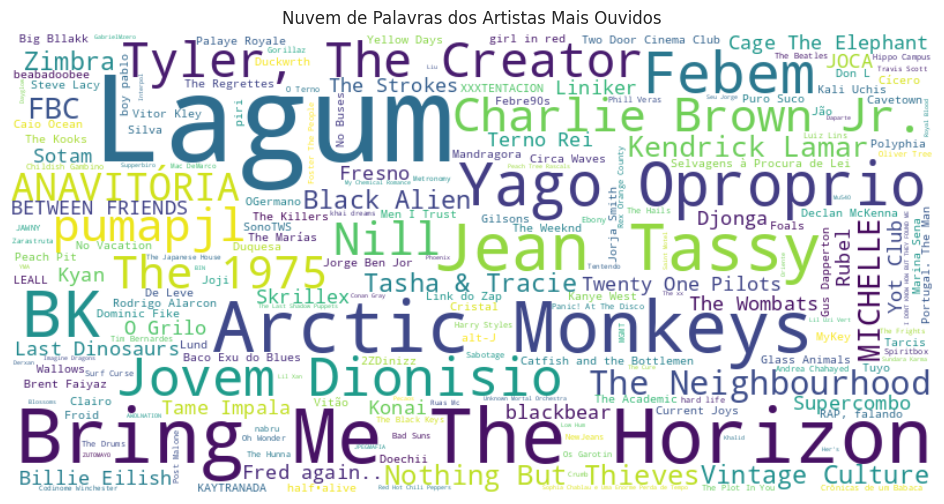

In [11]:
artist_counts = df['master_metadata_album_artist_name'].value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(artist_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Artistas Mais Ouvidos')
plt.show()

##🔄 Análise de Sessões de Escuta

In [12]:
df = df.sort_values('ts')

df['time_diff'] = df['ts'].diff().dt.total_seconds() / 60

df['session_id'] = (df['time_diff'] > 30).cumsum()

sessions = df.groupby('session_id').agg({
    'ts': ['min', 'max'],
    'minutes_played': 'sum',
    'master_metadata_track_name': 'count'
}).reset_index()

sessions.columns = ['session_id', 'start_time', 'end_time', 'total_minutes', 'tracks_played']

sessions['session_duration'] = (sessions['end_time'] - sessions['start_time']).dt.total_seconds() / 60
sessions = sessions[sessions['session_duration'] >= 10]

fig = px.histogram(sessions, x='session_duration',
                   title='Distribuição da Duração das Sessões de Escuta',
                   labels={'session_duration': 'Duração da Sessão (minutos)'},
                   nbins=1000)
fig.update_xaxes(range=[10, 500])

fig.update_layout(bargap=0.1)
fig.show()

#📌 Principais Insights


In [13]:
total_minutes = df['minutes_played'].sum()
total_hours = total_minutes / 60
total_days = total_hours / 24
avg_daily_minutes = total_minutes / len(df['date'].unique())

top_artist_by_plays = df['master_metadata_album_artist_name'].value_counts().idxmax()
top_track_by_plays = df.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name']).size().idxmax()

print(f"\n🔍 Principais Insights:\n")
print(f"• Você ouviu {total_minutes:,.0f} minutos de música (~{total_hours:,.1f} horas ou ~{total_days:,.1f} dias)")
print(f"• Em média, você ouviu {avg_daily_minutes:.1f} minutos por dia")
print(f"• Seu artista mais reproduzido foi: {top_artist_by_plays}")
print(f"• Sua música mais reproduzida foi: '{top_track_by_plays[0]}' de {top_track_by_plays[1]}")
print(f"• Seu horário de pico de escuta foi às {hourly_dist.loc[hourly_dist['minutes_played'].idxmax(), 'hour']}h")
print(f"• Dia da semana que você tende a ouvir mais música: {daily_dist.loc[daily_dist['minutes_played'].idxmax(), 'day_of_week']}")


🔍 Principais Insights:

• Você ouviu 307,973 minutos de música (~5,132.9 horas ou ~213.9 dias)
• Em média, você ouviu 181.1 minutos por dia
• Seu artista mais reproduzido foi: Lagum
• Sua música mais reproduzida foi: 'Imprevisto' de Yago Oproprio
• Seu horário de pico de escuta foi às 19h
• Dia da semana que você tende a ouvir mais música: Wednesday
